# Email Phishing Dataset - Exploratory Data Analysis

Exploring the Seven Emails phishing dataset for BERT-LSTM model development.

**Dataset:** `data/unprocessed/email-detection/Seven Emails phishing dataset/`

## 1. Setup

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 2. Load Datasets

In [8]:
DATA_PATH = Path('../../../data/unprocessed/email-detection/Seven Emails phishing dataset')

csv_files = ['Assassin.csv', 'CEAS-08.csv', 'Enron.csv', 'Ling.csv', 'TREC-05.csv', 'TREC-06.csv', 'TREC-07.csv']

print('Dataset Files:')
print('='*60)
for file in csv_files:
    fp = DATA_PATH / file
    if fp.exists():
        print(f'{file:20s} - {fp.stat().st_size / (1024*1024):>8.2f} MB')
    else:
        print(f'{file:20s} - NOT FOUND')

Dataset Files:
Assassin.csv         -    14.19 MB
CEAS-08.csv          -    64.76 MB
Enron.csv            -    42.76 MB
Ling.csv             -     8.90 MB
TREC-05.csv          -   117.43 MB
TREC-06.csv          -    39.98 MB
TREC-07.csv          -    95.60 MB


In [9]:
def load_dataset(file_path, file_name):
    try:
        if file_name in ['TREC-05.csv', 'TREC-06.csv']:
            df = pd.read_csv(file_path, on_bad_lines='skip', engine='python', encoding='utf-8', quoting=1)
            return df, 'loaded_with_skipped_lines'
        else:
            df = pd.read_csv(file_path)
            return df, 'loaded_successfully'
    except Exception as e:
        return None, f'error: {str(e)}'

datasets = {}
print('\nLoading datasets...')
print('='*60)
for file in csv_files:
    df, status = load_dataset(DATA_PATH / file, file)
    if df is not None:
        datasets[file.replace('.csv', '')] = df
        print(f'✓ {file:20s} - {status}')
    else:
        print(f'✗ {file:20s} - {status}')

print(f'\nLoaded {len(datasets)} datasets')


Loading datasets...
✓ Assassin.csv         - loaded_successfully
✓ CEAS-08.csv          - loaded_successfully
✓ Enron.csv            - loaded_successfully
✓ Ling.csv             - loaded_successfully
✓ TREC-05.csv          - loaded_with_skipped_lines
✓ TREC-06.csv          - loaded_with_skipped_lines
✓ TREC-07.csv          - loaded_successfully

Loaded 7 datasets


## 3. Schema Analysis

In [10]:
print('Dataset Schemas:')
print('='*80)
for name, df in datasets.items():
    print(f'\n{name}: {df.shape}')
    print(f'  Columns: {list(df.columns)}')
    print(f'  Label dtype: {df["label"].dtype}')

Dataset Schemas:

Assassin: (5809, 7)
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
  Label dtype: int64

CEAS-08: (39154, 7)
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
  Label dtype: int64

Enron: (29767, 3)
  Columns: ['subject', 'body', 'label']
  Label dtype: int64

Ling: (2859, 3)
  Columns: ['subject', 'body', 'label']
  Label dtype: int64

TREC-05: (59015, 7)
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
  Label dtype: object

TREC-06: (16439, 7)
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
  Label dtype: float64

TREC-07: (53757, 7)
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
  Label dtype: int64


## 4. Label Distribution Analysis

In [11]:
print('Label Distribution:')
print('='*80)

summary_data = []

for name, df in datasets.items():
    print(f'\n{name}: {len(df):,} emails')
    
    # Get unique labels (handle mixed types)
    unique_labels = df['label'].dropna().unique()
    try:
        unique_sorted = sorted([x for x in unique_labels if pd.notna(x)])
    except TypeError:
        unique_sorted = sorted([str(x) for x in unique_labels if pd.notna(x)])
    
    print(f'  Unique labels: {unique_sorted[:10]}')
    if len(unique_sorted) > 10:
        print(f'  ... +{len(unique_sorted)-10} more')
    
    # Count top labels
    label_counts = df['label'].value_counts()
    print(f'  Top label values:')
    for label, count in label_counts.head(5).items():
        print(f'    {label}: {count:,} ({count/len(df)*100:.2f}%)')
    if len(label_counts) > 5:
        print(f'    ... +{len(label_counts)-5} more')
    
    # Count binary labels
    label_0 = (df['label'] == 0).sum()
    label_1 = (df['label'] == 1).sum()
    null_count = df['label'].isnull().sum()
    other = len(df) - label_0 - label_1
    
    summary_data.append({
        'Dataset': name,
        'Total': len(df),
        'Label_0': label_0,
        'Label_1': label_1,
        'Other': other,
        'Null': null_count,
        'Unique': len(unique_sorted)
    })

df_summary = pd.DataFrame(summary_data)
print('\n' + '='*80)
print('SUMMARY')
print('='*80)
print(df_summary.to_string(index=False))

Label Distribution:

Assassin: 5,809 emails
  Unique labels: [np.int64(0), np.int64(1)]
  Top label values:
    0: 4,091 (70.43%)
    1: 1,718 (29.57%)

CEAS-08: 39,154 emails
  Unique labels: [np.int64(0), np.int64(1)]
  Top label values:
    1: 21,842 (55.78%)
    0: 17,312 (44.22%)

Enron: 29,767 emails
  Unique labels: [np.int64(0), np.int64(1)]
  Top label values:
    0: 15,791 (53.05%)
    1: 13,976 (46.95%)

Ling: 2,859 emails
  Unique labels: [np.int64(0), np.int64(1)]
  Top label values:
    0: 2,401 (83.98%)
    1: 458 (16.02%)

TREC-05: 59,015 emails
  Unique labels: [' ""The Senate\'s economic proposal focuses more on the excise tax for rum and other special-interest breaks than creating jobs."" ', ' +1-415-894-9376', ' 128 Mb computers resources and is subject to delay and jitter due to end-users computer being used as a Proxy Server on the network. Management believes this to be one of the most complete and technologically advanced |ine of VoIP products currently availab|

In [ ]:
# Overall statistics
total = df_summary['Total'].sum()
total_0 = df_summary['Label_0'].sum()
total_1 = df_summary['Label_1'].sum()
total_other = df_summary['Other'].sum()

print('\n' + '='*80)
print('OVERALL STATISTICS')
print('='*80)
print(f'Total Emails: {total:,}')
print(f'Label 0 (Legitimate): {total_0:,} ({total_0/total*100:.2f}%)')
print(f'Label 1 (Phishing):   {total_1:,} ({total_1/total*100:.2f}%)')
print(f'Other Labels:         {total_other:,} ({total_other/total*100:.2f}%)')
print(f'\nAccounted: {total_0 + total_1 + total_other:,}')
print(f'Matches total: {total == (total_0 + total_1 + total_other)}')
print(f'\n⚠ MISSING {total - total_0 - total_1:,} emails between Label 0+1 vs Total')


OVERALL STATISTICS
Total Emails: 206,800
Label 0 (Legitimate): 76,346 (36.92%)
Label 1 (Phishing):   71,382 (34.52%)
Other Labels:         59,072 (28.56%)

Accounted: 206,800
Matches total: True

⚠ MISSING 59,072 emails between Label 0+1 vs Total


## 5. Visualizations

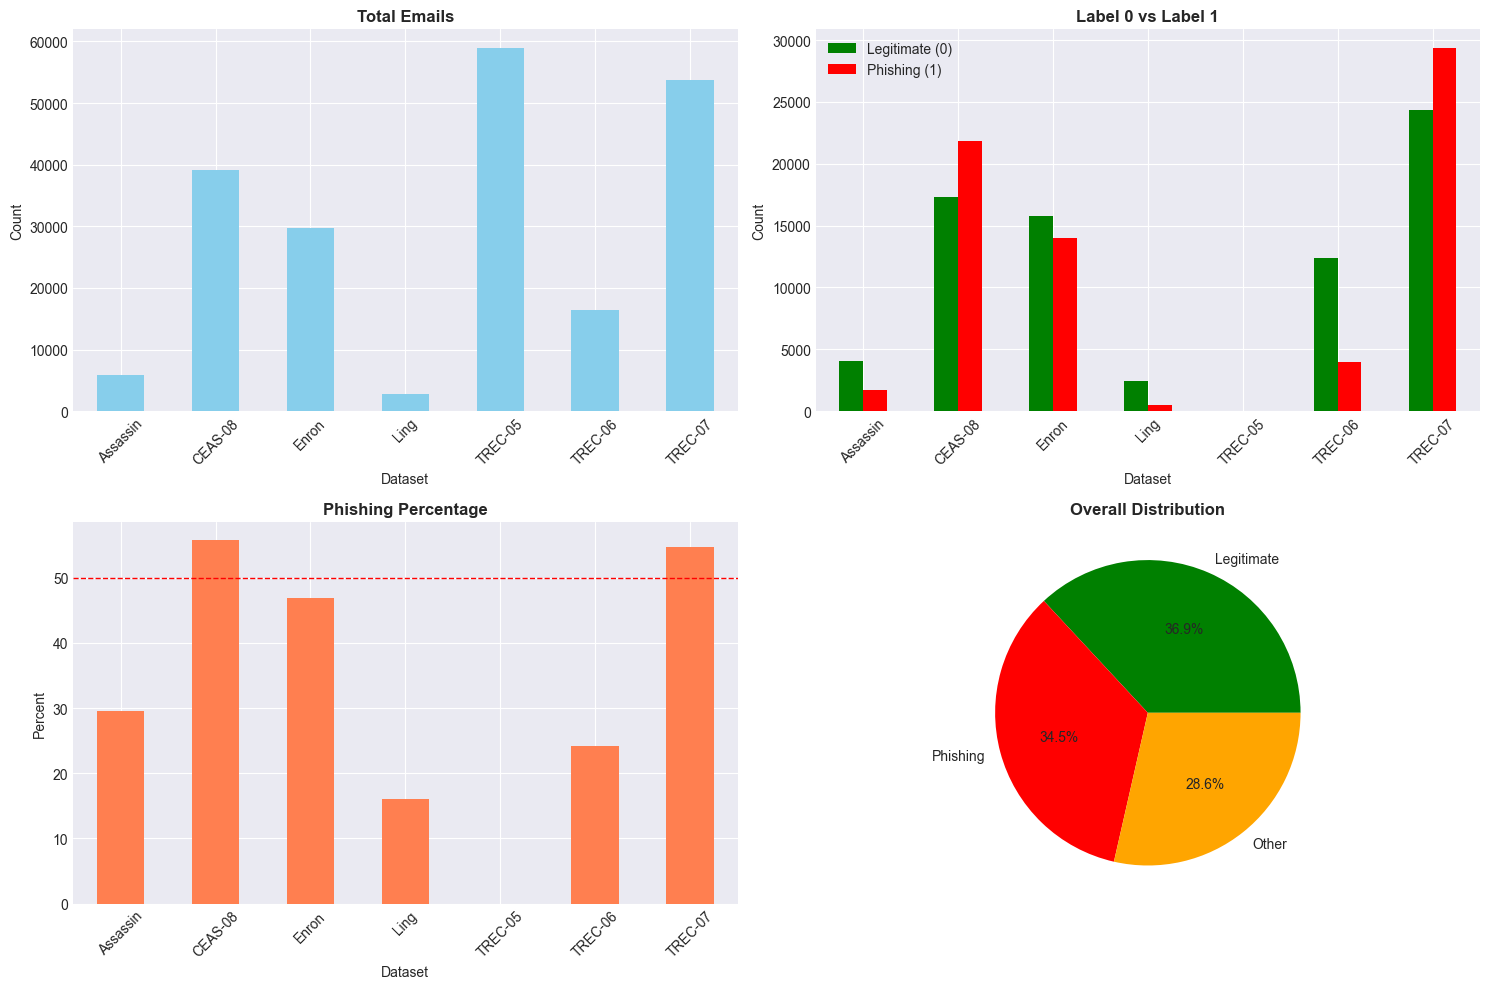

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total emails
df_summary.plot(x='Dataset', y='Total', kind='bar', ax=axes[0,0], legend=False, color='skyblue')
axes[0,0].set_title('Total Emails', fontweight='bold')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Class distribution
df_summary.plot(x='Dataset', y=['Label_0', 'Label_1'], kind='bar', ax=axes[0,1], color=['green', 'red'])
axes[0,1].set_title('Label 0 vs Label 1', fontweight='bold')
axes[0,1].set_ylabel('Count')
axes[0,1].legend(['Legitimate (0)', 'Phishing (1)'])
axes[0,1].tick_params(axis='x', rotation=45)

# Phishing percentage
df_summary['Phish_Pct'] = (df_summary['Label_1'] / df_summary['Total']) * 100
df_summary.plot(x='Dataset', y='Phish_Pct', kind='bar', ax=axes[1,0], legend=False, color='coral')
axes[1,0].set_title('Phishing Percentage', fontweight='bold')
axes[1,0].set_ylabel('Percent')
axes[1,0].axhline(50, color='red', linestyle='--', linewidth=1)
axes[1,0].tick_params(axis='x', rotation=45)

# Overall pie
axes[1,1].pie([total_0, total_1, total_other], labels=['Legitimate', 'Phishing', 'Other'], 
              autopct='%1.1f%%', colors=['green', 'red', 'orange'])
axes[1,1].set_title('Overall Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Text Analysis (Assassin Dataset)

In [10]:
df_sample = datasets['Assassin'].copy()

print(f'Sample Dataset: Assassin - {df_sample.shape}')
print(f'Columns: {list(df_sample.columns)}')
df_sample.head(2)

Sample Dataset: Assassin - (5809, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']


,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 From: Chris Garrigues Message-ID: ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoogroups.com>","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Greek sculptor behind the plan, judged that the\n lim...",0,1


In [ ]:
# Text lengths
df_sample['body_len'] = df_sample['body'].fillna('').astype(str).apply(len)
df_sample['subj_len'] = df_sample['subject'].fillna('').astype(str).apply(len)
df_sample['words'] = df_sample['body'].fillna('').astype(str).apply(lambda x: len(x.split()))

print('Text Stats by Label:')
print(df_sample.groupby('label')[['body_len', 'subj_len', 'words']].describe())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Body length
df_sample[df_sample['label']==0]['body_len'].hist(bins=50, alpha=0.6, ax=axes[0], color='green', label='Legit')
df_sample[df_sample['label']==1]['body_len'].hist(bins=50, alpha=0.6, ax=axes[0], color='red', label='Phishing')
axes[0].set_title('Body Length Distribution')
axes[0].set_xlabel('Characters')
axes[0].set_xlim(0, 5000)
axes[0].legend()

# Word count
df_sample[df_sample['label']==0]['words'].hist(bins=50, alpha=0.6, ax=axes[1], color='green', label='Legit')
df_sample[df_sample['label']==1]['words'].hist(bins=50, alpha=0.6, ax=axes[1], color='red', label='Phishing')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Words')
axes[1].set_xlim(0, 800)
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Sample Emails

In [ ]:
print('SAMPLE LEGITIMATE EMAIL')
print('='*80)
s = df_sample[df_sample['label']==0].iloc[0]
print(f'Subject: {s["subject"]}')
print(f'Body: {str(s["body"])[:400]}...')

In [ ]:
print('SAMPLE PHISHING EMAIL')
print('='*80)
if (df_sample['label']==1).any():
    s = df_sample[df_sample['label']==1].iloc[0]
    print(f'Subject: {s["subject"]}')
    print(f'Body: {str(s["body"])[:400]}...')
else:
    print('No phishing samples found')